## Implement Markowitz model 
### Set up long positions using all wealth. Diversification of portfolio i.e combining multiple assets helps reduce unsystematic risk. Including low or non-correlated stocks, bonds, commodities, etc. in the portfolio helps minimize risk.  

### Using Monte Carlo simulation show expected returns and risk for different portfolions. Then perform portfolio optimization and find best portfolio using Sharpe ratio


In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# on average there are 252 trading days in a year
NUM_TRADING_DAYS = 252
# we will generate random w (different portfolios)
NUM_PORTFOLIOS = 10000

In [53]:
# stocks we are going to handle
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']

# historical data - define START and END dates
start_date = '2012-01-01'
end_date = '2022-10-10'

In [54]:
def download_data():
    # name of the stock (key) - stock values (2012-2022) as the values
    stock_data = {}

    for stock in stocks:
        # closing prices
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']

    return pd.DataFrame(stock_data)


def show_data(data):
    data.plot(figsize=(15, 8))
    plt.show()


### Visualize the stock closing prices from 01 Jan 2012 to 10 Oct 2022

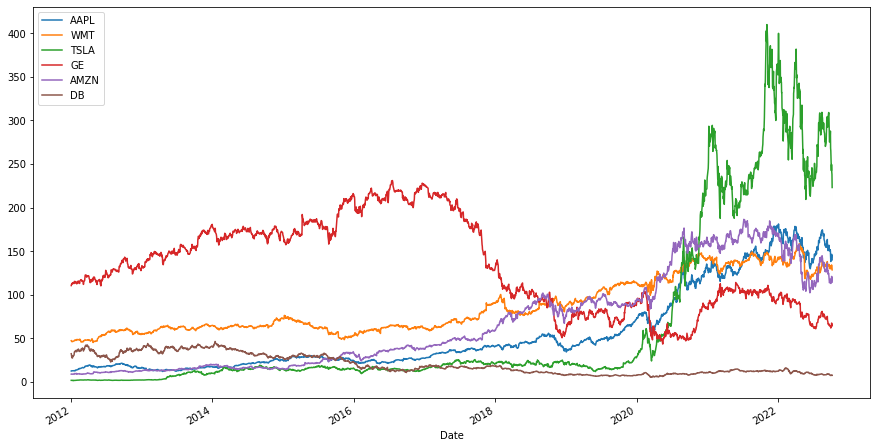

In [55]:
dataset = download_data()
show_data(dataset)

In [56]:
def calculate_return(data):
    # NORMALIZATION - to measure all variables in comparable metric
    log_return = np.log(data / data.shift(1))
    return log_return[1:]


def show_statistics(returns):
    # instead of daily metrics we are after annual metrics
    # mean of annual return
    display(returns.mean() * NUM_TRADING_DAYS)
    display(returns.cov() * NUM_TRADING_DAYS)

def show_mean_variance(returns, weights):
    # we are after the annual return
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)

### Show the log daily returns for the assets in the portfolio (in %)

In [57]:
log_daily_returns = calculate_return(dataset)
log_daily_returns

,AAPL,WMT,TSLA,GE,AMZN,DB
Date,,,,,,
2012-01-04,0.005359,-0.010330,-0.013264,0.010834,-0.008526,-0.030591
2012-01-05,0.011041,-0.004869,-0.021522,-0.000538,0.000563,-0.064142
2012-01-06,0.010399,-0.007094,-0.007773,0.005376,0.027763,-0.055909
2012-01-09,-0.001587,0.003046,0.012556,0.011197,-0.022428,-0.018263
2012-01-10,0.003574,-0.002368,0.013486,-0.007451,0.004359,0.044478
...,...,...,...,...,...,...
2022-10-03,0.030289,0.021585,-0.090084,0.026932,0.025167,0.017415
2022-10-04,0.025300,0.012895,0.028629,0.060107,0.043979,0.077895
2022-10-05,0.002051,-0.009956,-0.035210,-0.001482,-0.001157,-0.038828


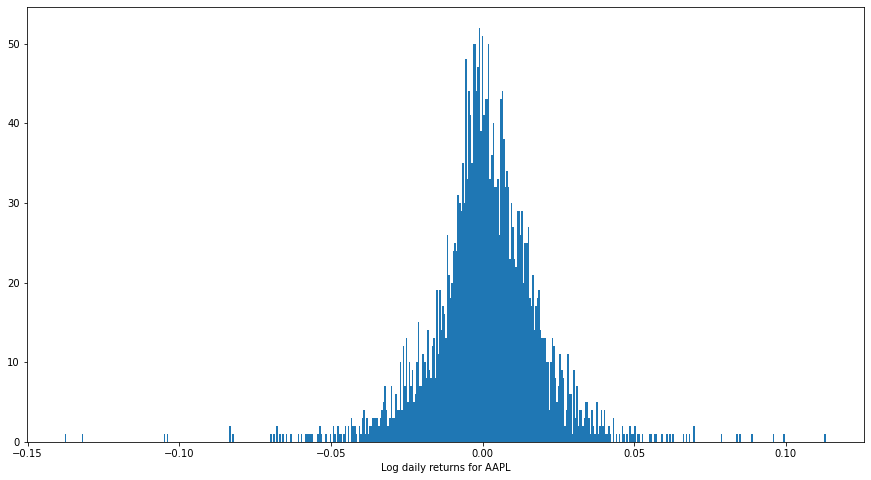

In [58]:
fig = plt.figure(figsize=(15,8))
plt.hist(log_daily_returns['AAPL'],bins=500)
plt.xlabel('Log daily returns for AAPL')
plt.show()

### Show annual expected returns and covariance matrix for the assets in the portfolio (in %)

In [59]:
show_statistics(log_daily_returns)

AAPL    0.224498
WMT     0.092948
TSLA    0.444696
GE     -0.050051
AMZN    0.237142
DB     -0.134075
dtype: float64

,AAPL,WMT,TSLA,GE,AMZN,DB
AAPL,0.083292,0.017195,0.058573,0.030505,0.044298,0.037020
WMT,0.017195,0.040638,0.016311,0.011806,0.015613,0.014243
TSLA,0.058573,0.016311,0.316863,0.040709,0.064669,0.054401
GE,0.030505,0.011806,0.040709,0.105691,0.025946,0.058598
AMZN,0.044298,0.015613,0.064669,0.025946,0.102157,0.036452
DB,0.037020,0.014243,0.054401,0.058598,0.036452,0.160588


### Show annual expected returns and covariance matrix for an example portfolio with weights [0.2,0.1,0.3,0.2,0.2,0.1]  (in %)

In [63]:
show_mean_variance(log_daily_returns,np.array([0.2,0.1,0.3,0.2,0.1,0.1]))

Expected portfolio mean (return):  0.1878995503735632
Expected portfolio volatility (standard deviation):  0.26591083855811704


In [68]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov()
                                                          * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

def show_portfolios(returns, volatilities):
    plt.figure(figsize=(15, 8))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

### Show portfolios along with expected returns and volatility 

#### Yellow indicates efficient frontier

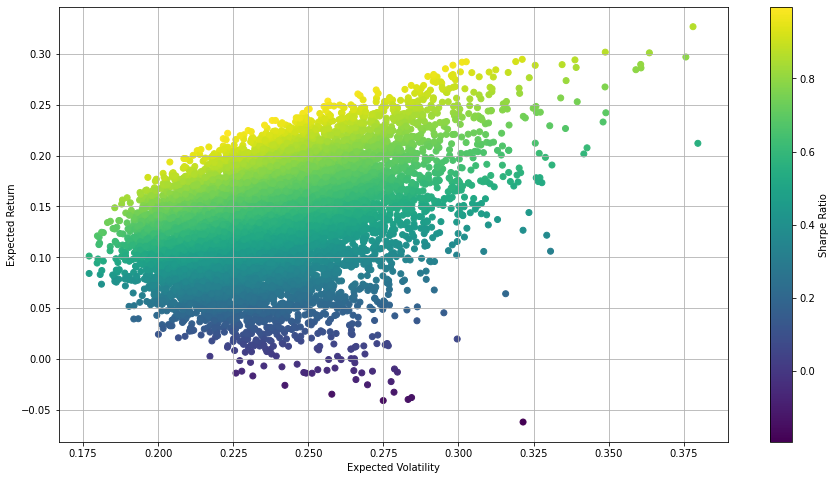

In [69]:
pweights, means, risks = generate_portfolios(log_daily_returns)
show_portfolios(means, risks)

In [66]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility,
                     portfolio_return / portfolio_volatility])


# scipy optimize module can find the minimum of a given function
# the maximum of a f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]


# what are the constraints? The sum of weights = 1 !!!
# f(x)=0 this is the function to minimize
def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # the weights can be 1 at most: 1 when 100% of money is invested into a single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns
                                 , method='SLSQP', bounds=bounds, constraints=constraints)


def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ",
          statistics(optimum['x'].round(3), returns))


def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(15, 8))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

Optimal portfolio:  [0.311 0.231 0.213 0.    0.245 0.   ]
Expected return, volatility and Sharpe ratio:  [0.24410986 0.24048981 1.01505285]


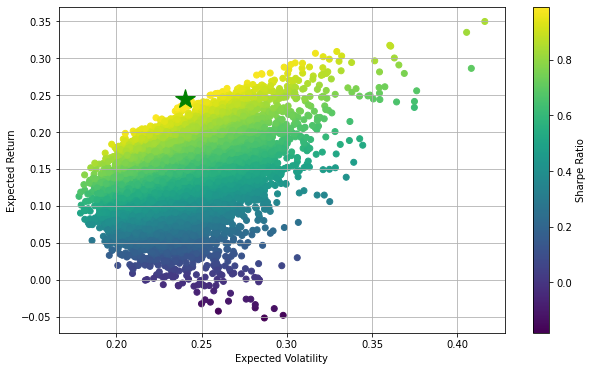

In [67]:
optimum = optimize_portfolio(pweights, log_daily_returns)
print_optimal_portfolio(optimum, log_daily_returns)
show_optimal_portfolio(optimum, log_daily_returns, means, risks)